<a href="https://colab.research.google.com/github/edinaldoab/challenge_data_science_2/blob/main/notebooks/semana02_tratamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semana 2
### Contextualização


Aqui será empregado uma abordagem de **Ciências de Dados**! Toda a base tratada e disponibilizada no formato PARQUET será explorada e tratada para finalmente elencar e criar os modelos de Machine Learning.
<br>
<br>
**Recordando: Na primeira semana do desafio, todos os esforços foram dedicados ao tratamento da base de dados bruta disponibilizada pelos desafiadores.**

# 1. Preparação do Ambiente

## a. Instalação das dependências

In [1]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

## b. Inicialização da SparkSession

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("challenge_imob") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

## c. Montagem do Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## d. Inicializando a  UI do Spark 

In [ ]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/projeto_data_science_imobni/dados/authTokenngrok.txt', 'r') as file:
  content = file.read()
  file.close()

my_authtoken = str(content)

In [ ]:
get_ipython().system_raw('./ngrok authtoken ' + my_authtoken)
get_ipython().system_raw('./ngrok http 4050 &')

!curl -s http://localhost:4040/api/tunnels

{"tunnels":[{"name":"command_line","uri":"/api/tunnels/command_line","public_url":"https://331a-34-75-20-66.ngrok.io","proto":"https","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}},{"name":"command_line (http)","uri":"/api/tunnels/command_line%20%28http%29","public_url":"http://331a-34-75-20-66.ngrok.io","proto":"http","config":{"addr":"http://localhost:4050","inspect":true},"metrics":{"conns":{"count":0,"gauge":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0},"http":{"count":0,"rate1":0,"rate5":0,"rate15":0,"p50":0,"p90":0,"p95":0,"p99":0}}}],"uri":"/api/tunnels"}


In [ ]:
spark

Carregamento dos dados:

# 2. Carregamento e tratamento dos dados

## a. Leitura do dataset

In [65]:
path='/content/drive/MyDrive/Colab Notebooks/projeto_data_science_imobni/dataset_parquet'

data = spark.read.parquet(path)

In [66]:
data.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+-------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|         bairro|      zona|condominio| iptu| tipo|  valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+---------------+----------+----------+-----+-----+-------+
|00790b85-56e3-43a...|   11|       166|      166|        5|[Academia, Churra...|      4|     4|       Usado| Apartamento|Residencial|   2|    Jacarepaguá|Zona Oeste|      2100| 4600|Venda|1750000|
|007f8099-8e1d-45f...|    4|       640|      640|        5|[Animais permitid...|     11|     3|       Usado| Apartamento|Residencial|null|           Urca|  Zona Sul|      3060|20030|Venda|3800000|
|00b23c6d-0e9d-

## b. Seleção de features

Aqui devem ser removidas as colunas que possuem apenas um valor atribuído, de acordo com o que foi elaborado na primeira semana. Esta etapa é muito importante para se reduzir a complexidade dos dados e aumentar a velocidade de ajuste do modelo.

In [67]:
data\
    .select('tipo')\
    .distinct()\
    .show(5)

+-----+
| tipo|
+-----+
|Venda|
+-----+



In [68]:
data\
    .select('tipo_anuncio')\
    .distinct()\
    .show(5)

+------------+
|tipo_anuncio|
+------------+
|       Usado|
+------------+



In [69]:
data\
    .select('tipo_unidade')\
    .distinct()\
    .show(5)

+------------+
|tipo_unidade|
+------------+
| Apartamento|
+------------+



In [70]:
data\
    .select('tipo_uso')\
    .distinct()\
    .show(5)

+-----------+
|   tipo_uso|
+-----------+
|Residencial|
+-----------+



As colunas `area_total` e `area_util` têm um potencial maior de aderência ao modelo. Assim, analisa-se:

In [71]:
data\
    .select('area_total','area_util')\
    .show(5)

+----------+---------+
|area_total|area_util|
+----------+---------+
|       166|      166|
|       640|      640|
|        50|       50|
|       160|      160|
|        52|       52|
+----------+---------+
only showing top 5 rows



In [72]:
data\
    .select('area_util', 'area_total')\
    .na\
    .drop()\
    .show(5)

+---------+----------+
|area_util|area_total|
+---------+----------+
|      166|       166|
|      640|       640|
|       50|        50|
|      160|       160|
|       52|        52|
+---------+----------+
only showing top 5 rows



In [73]:
from pyspark.sql import functions as f

dados_without_na = data\
    .select('area_util', 'area_total')\
    .na\
    .drop()

quantidade_total = dados_without_na.count()
quantidade_iguais = dados_without_na.filter(f.col('area_util') == f.col('area_total')).count()
quantidade_distintas = quantidade_total - quantidade_iguais

print(f'Quantidade de linhas: {quantidade_total}')
print(f'Quantidade de linhas com area_util == area_total: {quantidade_iguais}')
print(f'Quantidade de linhas diferentes: {quantidade_distintas}')

Quantidade de linhas: 57368
Quantidade de linhas com area_util == area_total: 55384
Quantidade de linhas diferentes: 1984


Chega-se a algumas conclusões:
<br>
<br>
*  das 57368 linhas, 55384 possuem valores iguais nas colunas `area_total` e `area_util`
*  pode-se escolher somente uma, uma vez que a maioria das informações são repetidas

Para esta escolha, levou-se em conta a coluna com a menor quantidade de dados nulos:

In [74]:
colunas = ['area_total', 'area_util']

data\
    .select([f.count(f.when(data[c].isNull(), True)).alias(c) for c in colunas])\
    .show()

+----------+---------+
|area_total|area_util|
+----------+---------+
|      9194|        0|
+----------+---------+



In [75]:
'''
cont = []
for c in colunas:
    cont.append(f.count(f.when(data[c].isNull(), True)).alias(c))

data.select(cont).show()

SyntaxError: ignored

A `area_total` não possui nenhum valor nulo! Pode-se então eliminar a coluna `area_util`.

In [76]:
data = data\
    .drop('area_total','tipo_anuncio','tipo_unidade','tipo_uso','tipo')

In [77]:
data.show(5)

+--------------------+-----+---------+---------+--------------------+-------+------+----+---------------+----------+----------+-----+-------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|         bairro|      zona|condominio| iptu|  valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+---------------+----------+----------+-----+-------+
|00790b85-56e3-43a...|   11|      166|        5|[Academia, Churra...|      4|     4|   2|    Jacarepaguá|Zona Oeste|      2100| 4600|1750000|
|007f8099-8e1d-45f...|    4|      640|        5|[Animais permitid...|     11|     3|null|           Urca|  Zona Sul|      3060|20030|3800000|
|00b23c6d-0e9d-4be...|    1|       50|        1|[Academia, Churra...|      2|     0|   1|Parada de Lucas|Zona Norte|       363|   97| 192000|
|012aebd7-278f-4b4...|    0|      160|        4|          [Elevador]|      3|     1|   3|        Ipanema|  Zona Sul|      1530| 7440|3490000|
|0267d

## c. Conversão dos tipos das colunas

In [78]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



Os dados numéricos estão tipados em sua maioria como string, enquanto deveriam receber as seguintes conversões:



In [79]:
from pyspark.sql.types import IntegerType, DoubleType

In [80]:
data = data\
    .withColumn('andar', data['andar'].cast(IntegerType()))\
    .withColumn('area_util', data['area_util'].cast(DoubleType()))\
    .withColumn('banheiros', data['banheiros'].cast(IntegerType()))\
    .withColumn('quartos', data['quartos'].cast(IntegerType()))\
    .withColumn('suites', data['suites'].cast(IntegerType()))\
    .withColumn('condominio', data['condominio'].cast(DoubleType()))\
    .withColumn('vaga', data['vaga'].cast(IntegerType()))\
    .withColumn('iptu', data['iptu'].cast(DoubleType()))\
    .withColumn('valor', data['valor'].cast(DoubleType()))

In [81]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



## d. Tratamento da coluna `caracteristicas`

In [82]:
data\
    .select('caracteristicas')\
    .show(100, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------+
|caracteristicas                                                                                                                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------+
|[Academia, Churrasqueira, Piscina, Playground, Salão de festas, Elevador, Condomínio fechado, Portão eletrônico, Portaria 24h, Animais permitidos]|
|[Animais permitidos, Portão eletrônico]                                                                                                           |
|[Academia, Churrasqueira, Piscina, Playground, Salão de festas, Condomínio fechado, Portaria 24h, Animais permitidos]                             |
|[Elevador]                                                                                               

A consulta da coluna característica mostra que algumas listas atribuídas estão vazias. A tratativa para este caso, é convertê-las para `null`:

In [83]:
data = data.withColumn('caracteristicas', f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col('caracteristicas')))

In [84]:
data.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|00790b85-56e3-43a...|   11|    166.0|        5|[Academia, Churra...|      4|     4|   2|         Jacarepaguá|Zona Oeste|    2100.0| 4600.0|1750000.0|
|007f8099-8e1d-45f...|    4|    640.0|        5|[Animais permitid...|     11|     3|null|                Urca|  Zona Sul|    3060.0|20030.0|3800000.0|
|00b23c6d-0e9d-4be...|    1|     50.0|        1|[Academia, Churra...|      2|     0|   1|     Parada de Lucas|Zona Norte|     363.0|   97.0| 192000.0|
|012aebd7-278f-4b4...|    0|    160.0|        4|          [Elevador]|      3|     1|   3|     

## e. Tratamento dos dados faltantes

Como os modelos de ML não lidam bem com dados faltantes, analisa-se onde e o quanto eles estão alocados nas colunas:

In [85]:
data\
    .select([f.count(f.when(data[c].isNull(), True)).alias(c) for c in data.columns])\
    .show()

+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
| id|andar|area_util|banheiros|caracteristicas|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+
|  0|    0|        0|        0|          12736|      0|  5554|3017|     0|   0|      2371|7199|    0|
+---+-----+---------+---------+---------------+-------+------+----+------+----+----------+----+-----+



In [86]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



Para os dados numéricos, trocam-se os valores nulos pelo número zero:

In [87]:
data = data\
    .select('*')\
    .na\
    .fill(0)

In [88]:
data.show()

+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|                  id|andar|area_util|banheiros|     caracteristicas|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|
+--------------------+-----+---------+---------+--------------------+-------+------+----+--------------------+----------+----------+-------+---------+
|00790b85-56e3-43a...|   11|    166.0|        5|[Academia, Churra...|      4|     4|   2|         Jacarepaguá|Zona Oeste|    2100.0| 4600.0|1750000.0|
|007f8099-8e1d-45f...|    4|    640.0|        5|[Animais permitid...|     11|     3|   0|                Urca|  Zona Sul|    3060.0|20030.0|3800000.0|
|00b23c6d-0e9d-4be...|    1|     50.0|        1|[Academia, Churra...|      2|     0|   1|     Parada de Lucas|Zona Norte|     363.0|   97.0| 192000.0|
|012aebd7-278f-4b4...|    0|    160.0|        4|          [Elevador]|      3|     1|   3|     

Em seguida, analisa-se a coluna não numérica `zona`:

In [89]:
data\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



Os 11 valores que possuem como zona uma string vazia, podem ser desconsiderados:

In [90]:
data = data.filter(f.col('zona') != '')

In [91]:
data\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
+------------+-----+



# Preparação dos dados para o modelo de ML

## a. Variáveis dummy

As variáveis categóricas serão transformadas em variáveis binárias. Isto é, se a variável tem uma categoria atribuída, ela receberá 1, caso o contrário, receberá 0.

Antes, deve-se desmembrar o conjunto `características` em outro dataset e o de `zona` também.

Desmembrando a coluna `caracteristicas` em outro dataset:

In [99]:
data\
    .select("*", f.explode("caracteristicas").alias("cara"))\
    .groupBy("id")\
    .pivot('cara')\
    .agg(f.lit(1))\
    .na\
    .fill(0)\
    .show(truncate=False)

+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|id                                  |Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+------------------------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|1bbc40f3-4f5c-4595-99b1-56ef42a54ede|1       |0                 |0            |1                 |1       |1      |1         |1           |1                |1              |
|afecddff-f4cc-4ab8-bdbf-242b7dff7241|1       |1                 |1            |1                 |1       |1      |1         |1           |1                |1              |
|bfffedfe-99e7-4aed-9a9f-f766225a0f1f|0       |1                 |1            |1                 |1       |0      |1        

In [102]:
caracteristicas = data\
    .select('*', f.explode('caracteristicas').alias('cara'))\
    .groupby('id')\
    .pivot('cara')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [103]:
caracteristicas.show(5)

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|1bbc40f3-4f5c-459...|       1|                 0|            0|                 1|       1|      1|         1|           1|                1|              1|
|afecddff-f4cc-4ab...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|               

In [104]:
zona = data\
    .groupby('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

In [105]:
zona.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows



## b. Montando o conjunto de dados completo

In [106]:
cont_rows_original = data.count()

In [107]:
data = data\
    .join(zona, 'id', how='inner')\
    .join(caracteristicas, 'id', how='left')\
    .drop('zona','cara','caracteristicas')\
    .na\
    .fill(0)

Validando se os joins realizados não comprometerão a quantidade de linhas da base original:

In [108]:
print(f'#linhas antes: {cont_rows_original}')
print(f'#linhas depois: {data.count()}')
print(f'#linhas perdidas: {cont_rows_original - data.count()}')

#linhas antes: 66551
#linhas depois: 66551
#linhas perdidas: 0


In [109]:
data.show(5)

+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|         bairro|condominio|   iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+---------------+----------+-------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00790b85-56e3-43a...|   11|    166.0|        5|      4|     4|   2|    Jacarepaguá|    2100.0| 4600.0|1750000.0|     

In [111]:
data.filter(f.col('id')=="be269ddf-a4a3-4a72-bd54-93cdccf512dd").show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio|iptu|   valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|be269ddf-a4a3-4a7...|    0|     45.0|        1|      2|     0|   1|Campo Grande|     356.0| 0.0|140000.0|           0|         0|         

# Disponibilização do dataset em PARQUET

In [123]:
data = data\
    .withColumnRenamed('Zona Central','zona_central')\
    .withColumnRenamed('Zona Norte','zona_norte')\
    .withColumnRenamed('Zona Oeste','zona_oeste')\
    .withColumnRenamed('Zona Sul','zona_sul')\
    .withColumnRenamed('Animais Permitidos','animais_permitidos')\
    .withColumnRenamed('Portaria 24h','portaria_24h')\
    .withColumnRenamed('Salão de festas','salao_de_festas')\
    .withColumnRenamed('Condomínio fechado','condominio_fechado')\
    .withColumnRenamed('Portão eletrônico','portao_eletronico')

In [124]:
data.write.parquet('/content/drive/MyDrive/Colab Notebooks/projeto_data_science_imobni/dataset_ml_regressao')

# Extra

## a. Análise de correlação

Com o intuito de detectar a redundância entre as variáveis, realiza-se a análise da **correlação** entre as variáveis numéricas da base:

In [125]:
from pyspark.ml.stat import Correlation

In [127]:
lista_zona = ['zona_central','zona_norte','zona_oeste','zona_sul']

lista_caracteristicas = ['condominio_fechado',
                        'Playground',
                        'portao_eletronico',
                        'Piscina',
                        'animais_permitidos',
                        'portaria_24h',
                        'Elevador',
                        'Academia',
                        'salao_de_festas',
                        'Churrasqueira']

In [129]:
input_col_corr = [i for i in data.columns if i not in ['id', 'bairro'] + lista_zona + lista_caracteristicas]

print(input_col_corr)

['andar', 'area_util', 'banheiros', 'quartos', 'suites', 'vaga', 'condominio', 'iptu', 'valor']


In [131]:
from pyspark.ml.feature import VectorAssembler

In [132]:
assembler = VectorAssembler(inputCols=input_col_corr,outputCol='features')

In [133]:
df = assembler.transform(data).select('features')

In [134]:
correlacao = Correlation.corr(df, 'features','pearson').collect()[0][0]

In [136]:
rows = correlacao.toArray().tolist()
df = spark.createDataFrame(rows,input_col_corr)

df.show(5)

+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               andar|           area_util|          banheiros|            quartos|              suites|                vaga|          condominio|                iptu|               valor|
+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|0.020674885718290365|0.01757715331670837|0.01008345278433918|0.024274113790925932|0.018271843474796625|0.006617930248883...|3.810955786364057...|0.016145590401859373|
|0.020674885718290365|                 1.0| 0.6710305514514978| 0.6740755967299021|  0.6201287358480546|  0.4719284382321347|0.045676565706072016|0.021337139034350524|  0.7586357636188664|
| 0.01757715331670837|  0.6710305514514978|            

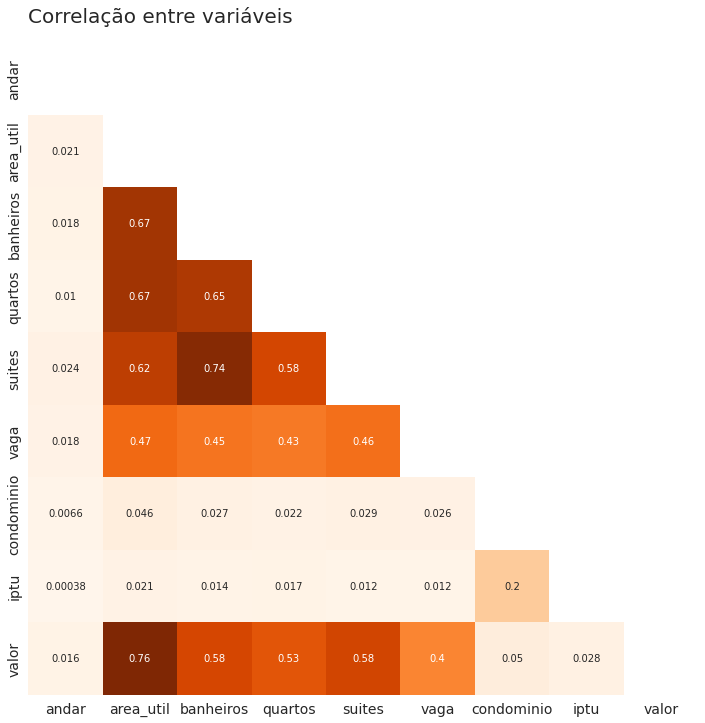

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.toPandas().set_index([input_col_corr])
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask, fmt=".2",  annot=True, cbar=False, cmap='Oranges')
    ax.tick_params(labelsize=14)
    ax.set_title('Correlação entre variáveis', fontsize=20, loc='left', pad=20)